In [1]:
import pandas as pd
import os, glob
import numpy as np

from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor

import sys
sys.path.append('../models/')
from models import build_model_cnn, build_model_gru

Using TensorFlow backend.
/home/fdz/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/fdz/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/fdz/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/fdz/anaconda3/lib/python3.7/site-packages/tensorflow/python

# Load data and build features

In [2]:
df_merged = pd.read_csv('../data_processed/df_fornitori.csv')
df_merged = df_merged[df_merged['Year'] >= 2016]
df_merged['Data_Aggiudicazione/Abilitazione'] = pd.to_datetime(df_merged['Data_Aggiudicazione/Abilitazione'],
                                                              format="%Y-%m-%d")

### Build features

In [3]:
to_drop = ['Partita_Iva', 'Progressivo_Partecipante', 'Denominazione_Partecipazione', 'Year', 'month', 'day', 'quarter']
cat_toreduce = ['Denominazione_Iniziativa', 'Denominazione_Lotto', 'Provincia_Sede_legale',
                   'Tipo_Strumento', 'Forma_Partecipazione', 'Flag_Capogruppo', 'Esito_Partecipazione',
       'Nazione_Sede_legale', 'Regione_Sede_legale', 'Forma_Societaria']
cat = []
n = 10
for col in cat_toreduce + cat:
    if col in cat_toreduce:
        # reduce number of categories for features in cat_toreduce. 
        # keep only top n category and replace the rest under "other"
        top = df_merged[col].value_counts()[:n]
        df_merged[col] = df_merged[col].apply(lambda x: x if x in top else 'other')
    dummies = pd.get_dummies(df_merged[col], prefix=col)
    df_merged = df_merged.merge(dummies, left_index=True, right_index=True)
    df_merged.drop(col, axis=1, inplace=True)
df_merged.drop(to_drop, axis=1, inplace=True)

In [4]:
df_merged['ep_tot'] = sum([df_merged[col] for col in df_merged.columns if 'Esito_Partecipazione' in col])
df_merged['target'] = df_merged['ep_tot']
#df_merged['Esito_Partecipazione_Abilitato'] + df_merged['Esito_Partecipazione_Aggiudicatario'] + df_merged['Esito_Partecipazione_Non Aggiudicatario']

In [5]:
agg_by = 'Data_Aggiudicazione/Abilitazione'
cols_first = ['Year', 'month', 'day', 'quarter']
cols = df_merged.columns.to_list()
cols.pop(cols.index(agg_by))

agg_dict = {col: 'first' if col in cols_first else 'sum' for col in cols}
df_fin = df_merged.groupby(agg_by).agg(agg_dict)

In [6]:
df_fin['ep_tot'].plot(figsize=(15, 8))

In [7]:
date_min = df_fin.index.min()
date_max = df_fin.index.max()
drange = pd.date_range(date_min, date_max, name=agg_by)

df_fin = df_fin.reindex(drange)
df_fin.fillna(0, inplace=True)

In [8]:
# sanity check
s_ept = df_fin.target
for cat in cat_toreduce:
    s_di = df_fin[[col for col in df_fin.columns if cat in col]].sum(axis=1)
    print(cat + ': ', (s_di == s_ept).all())

Denominazione_Iniziativa:  True
Denominazione_Lotto:  True
Provincia_Sede_legale:  True
Tipo_Strumento:  True
Forma_Partecipazione:  True
Flag_Capogruppo:  True
Esito_Partecipazione:  True
Nazione_Sede_legale:  True
Regione_Sede_legale:  True
Forma_Societaria:  True


Text(0, 0.5, 'Partecipazioni')

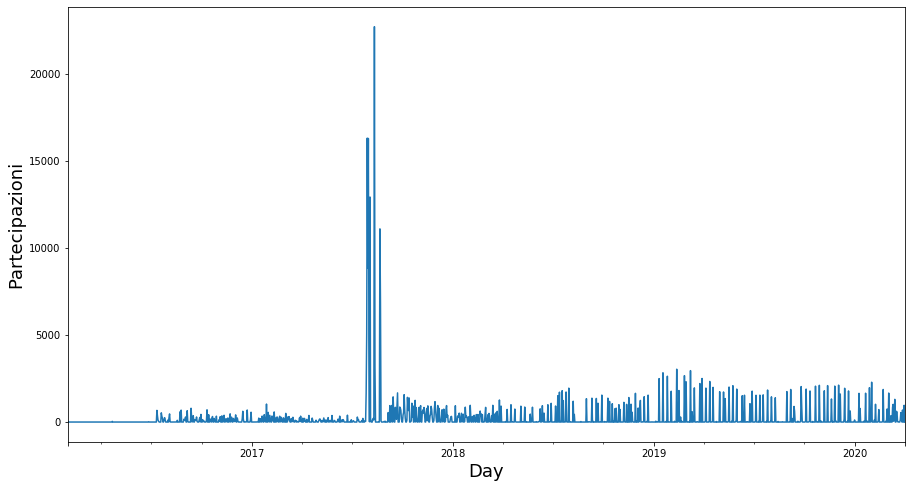

In [9]:
ax = df_fin['target'].plot(figsize=(15, 8))
ax.set_xlabel('Day', fontsize=18)
ax.set_ylabel('Partecipazioni', fontsize=18)

In [10]:
df_fin.to_csv('../data_processed/df_features_fornitori.csv')

In [11]:
df_fin.head()

,Denominazione_Iniziativa_BENI,Denominazione_Iniziativa_LAVORI DI MANUTENZIONE - AMBIENTE E TERRITORIO,Denominazione_Iniziativa_LAVORI DI MANUTENZIONE - BENI DEL PATRIMONIO CULTURALE,Denominazione_Iniziativa_LAVORI DI MANUTENZIONE - EDILI,"Denominazione_Iniziativa_LAVORI DI MANUTENZIONE - IDRAULICI, MARITTIMI E RETI GAS",Denominazione_Iniziativa_LAVORI DI MANUTENZIONE - IMPIANTI,Denominazione_Iniziativa_LAVORI DI MANUTENZIONE - OPERE SPECIALIZZATE,"Denominazione_Iniziativa_LAVORI DI MANUTENZIONE - STRADALI, FERROVIARI ED AEREI",Denominazione_Iniziativa_SERVIZI,Denominazione_Iniziativa_SERVIZI DI PULIZIA E IGIENE AMBIENTALE,...,Forma_Societaria_Professione non organizzata in ordini o collegi (cfr. L. 4/2013),Forma_Societaria_Professione organizzata (cfr. Art. 2229 cc),Forma_Societaria_Società Cooperativa,Forma_Societaria_Società a Responsabilità Limitata,Forma_Societaria_Società in Accomandita Semplice,Forma_Societaria_Società in Nome Collettivo,Forma_Societaria_Società per Azioni,Forma_Societaria_other,ep_tot,target
Data_Aggiudicazione/Abilitazione,,,,,,,,,,,,,,,,,,,,,
2016-02-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,2.0
2016-02-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-02-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,1.0,0.0,6.0,6.0
2016-02-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-02-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,2.0


# Predict daily partecipazioni regression

In [47]:
df_fin = pd.read_csv('../data_processed/df_features_fornitori.csv')
df_fin['Data_Aggiudicazione/Abilitazione'] = pd.to_datetime(df_fin['Data_Aggiudicazione/Abilitazione'],
                                                              format="%Y-%m-%d")
df_fin.set_index('Data_Aggiudicazione/Abilitazione', inplace=True)

In [48]:
df_fin.head()

,Denominazione_Iniziativa_BENI,Denominazione_Iniziativa_LAVORI DI MANUTENZIONE - AMBIENTE E TERRITORIO,Denominazione_Iniziativa_LAVORI DI MANUTENZIONE - BENI DEL PATRIMONIO CULTURALE,Denominazione_Iniziativa_LAVORI DI MANUTENZIONE - EDILI,"Denominazione_Iniziativa_LAVORI DI MANUTENZIONE - IDRAULICI, MARITTIMI E RETI GAS",Denominazione_Iniziativa_LAVORI DI MANUTENZIONE - IMPIANTI,Denominazione_Iniziativa_LAVORI DI MANUTENZIONE - OPERE SPECIALIZZATE,"Denominazione_Iniziativa_LAVORI DI MANUTENZIONE - STRADALI, FERROVIARI ED AEREI",Denominazione_Iniziativa_SERVIZI,Denominazione_Iniziativa_SERVIZI DI PULIZIA E IGIENE AMBIENTALE,...,Forma_Societaria_Professione non organizzata in ordini o collegi (cfr. L. 4/2013),Forma_Societaria_Professione organizzata (cfr. Art. 2229 cc),Forma_Societaria_Società Cooperativa,Forma_Societaria_Società a Responsabilità Limitata,Forma_Societaria_Società in Accomandita Semplice,Forma_Societaria_Società in Nome Collettivo,Forma_Societaria_Società per Azioni,Forma_Societaria_other,ep_tot,target
Data_Aggiudicazione/Abilitazione,,,,,,,,,,,,,,,,,,,,,
2016-02-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,2.0
2016-02-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-02-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,1.0,0.0,6.0,6.0
2016-02-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-02-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,2.0


In [49]:
df_fin['target'] = df_fin['target'].shift(-1)
df_fin.dropna(inplace=True)

In [50]:
features = [col for col in df_fin.columns if col != 'target']
def rolling_window(a, window):
    shape = (a.shape[0] - window + 1, window) + a.shape[1:]
    strides = (a.strides[0],) + a.strides
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

## Baselines

### Split train test

In [51]:
X = df_fin[features].values
y = df_fin['target'].values
X_train, y_train = X[:int(0.7 * len(X))], y[:int(0.7 * len(X))]
X_test, y_test = X[int(0.7 * len(X)):], y[int(0.7 * len(X)):]

In [52]:
X_test.shape

(456, 78)

### Scale feats

In [53]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Mean

In [54]:
class MeanPredictor():
    
    def __init__(self):
        self.mean = None
    
    def fit(self, X_train, y_train):
        self.mean = y_train.mean()
        
    def predict(self, X):
        return np.full(len(X), self.mean)

In [55]:
mp = MeanPredictor()
mp.fit(X_train, y_train)

In [56]:
preds_train = mp.predict(X_train)
preds_test = mp.predict(X_test) 
print('Train error:', mean_absolute_error(y_train, preds_train))
print('Test error: ', mean_absolute_error(y_test, preds_test))

Train error: 363.870117021878
Test error:  413.7400079145231


### Linear regression

In [57]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [58]:
preds_train = lr.predict(X_train)
preds_test = lr.predict(X_test)
print('Train error:', mean_absolute_error(y_train, preds_train))
print('Test error: ', mean_absolute_error(y_test, preds_test))

Train error: 321.0736310792887
Test error:  459.7918724622966


### xgboost

In [59]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

[16:10:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [60]:
preds_train = xgb.predict(X_train)
preds_test = xgb.predict(X_test)
print('Train error:', mean_absolute_error(y_train, preds_train))
print('Test error: ', mean_absolute_error(y_test, preds_test))

Train error: 190.42247860548193
Test error:  579.0130070176041


## Sequences

### Split train test

In [61]:
window_size = 30
X_rolled = rolling_window(X, window_size)
y_rolled = rolling_window(y, window_size)[:, -1]
#index_rolled = rolling_window(index.values, window_size)[:, -1]

In [62]:
X_train, y_train = X_rolled[:int(0.7 * len(X_rolled))], y_rolled[:int(0.7 * len(y_rolled))]
#index_train = index_rolled[:int(0.7 * len(y_rolled))]
X_test, y_test = X_rolled[int(0.7 * len(X_rolled)):], y_rolled[int(0.7 * len(y_rolled)):]
#index_test = index_rolled[int(0.7 * len(y_rolled)):]

### Model gru

In [63]:
gru = build_model_gru(X_train.shape[2], window_size, 
                      nb_hidden_1=100, nb_hidden_2=50, emb_dim=20, 
                      dropout_1=0.2, dropout_2=0.2, rec_dropout_1=0.2, rec_dropout_2=0.2, 
                      model_type='regression')

In [64]:
gru.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_part (InputLayer)      (None, 30, 78)            0         
_________________________________________________________________
gru_5 (GRU)                  (None, 30, 100)           53700     
_________________________________________________________________
gru_6 (GRU)                  (None, 50)                22650     
_________________________________________________________________
dense_5 (Dense)              (None, 20)                1020      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 21        
Total params: 77,391
Trainable params: 77,391
Non-trainable params: 0
_________________________________________________________________


In [65]:
gru.fit(X_train, y_train, epochs=100)

Epoch 1/100
1043/1043 [==============================] - 3s 3ms/step - loss: 250.4374 - mean_absolute_error: 250.4374
Epoch 2/100
1043/1043 [==============================] - 1s 1ms/step - loss: 250.3250 - mean_absolute_error: 250.3250
Epoch 3/100
1043/1043 [==============================] - 1s 1ms/step - loss: 250.0443 - mean_absolute_error: 250.0443
Epoch 4/100
1043/1043 [==============================] - 1s 1ms/step - loss: 249.8205 - mean_absolute_error: 249.8205
Epoch 5/100
1043/1043 [==============================] - 1s 1ms/step - loss: 249.4717 - mean_absolute_error: 249.4717
Epoch 6/100
1043/1043 [==============================] - 2s 2ms/step - loss: 249.0326 - mean_absolute_error: 249.0326
Epoch 7/100
1043/1043 [==============================] - 1s 1ms/step - loss: 248.7126 - mean_absolute_error: 248.7126
Epoch 8/100
1043/1043 [==============================] - 1s 1ms/step - loss: 248.4805 - mean_absolute_error: 248.4805
Epoch 9/100
1043/1043 [==============================] -

1043/1043 [==============================] - 1s 1ms/step - loss: 224.7890 - mean_absolute_error: 224.7890
Epoch 70/100
1043/1043 [==============================] - 1s 1ms/step - loss: 227.1624 - mean_absolute_error: 227.1624
Epoch 71/100
1043/1043 [==============================] - 2s 2ms/step - loss: 226.2826 - mean_absolute_error: 226.2826
Epoch 72/100
1043/1043 [==============================] - 1s 1ms/step - loss: 226.3166 - mean_absolute_error: 226.3166
Epoch 73/100
1043/1043 [==============================] - 1s 1ms/step - loss: 223.0738 - mean_absolute_error: 223.0738
Epoch 74/100
1043/1043 [==============================] - 1s 1ms/step - loss: 223.1014 - mean_absolute_error: 223.1014
Epoch 75/100
1043/1043 [==============================] - 1s 1ms/step - loss: 225.0806 - mean_absolute_error: 225.0806
Epoch 76/100
1043/1043 [==============================] - 1s 1ms/step - loss: 225.0476 - mean_absolute_error: 225.0476
Epoch 77/100
1043/1043 [==============================] - 1s 

In [66]:
preds_train = gru.predict(X_train)
preds_test = gru.predict(X_test)
print('Train error:', mean_absolute_error(y_train, preds_train))
print('Test error: ', mean_absolute_error(y_test, preds_test))

Train error: 203.99793106488963
Test error:  262.0646436890321


In [67]:
df_preds_train = pd.DataFrame()
df_preds_test = pd.DataFrame()
df_preds_train['y_train'] = y_train 
df_preds_train['preds_train'] = preds_train 
df_preds_test['y_test'] = y_test 
df_preds_test['preds_test'] = preds_test 


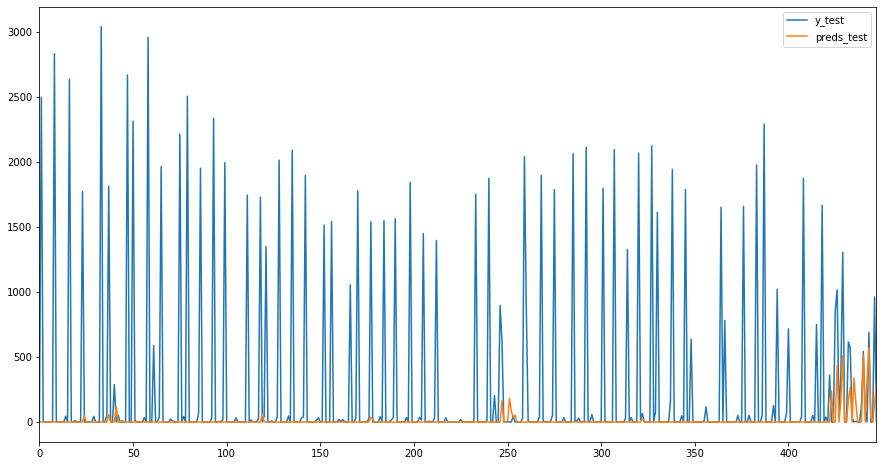

In [68]:
df_preds_test.plot(figsize=(15, 8))

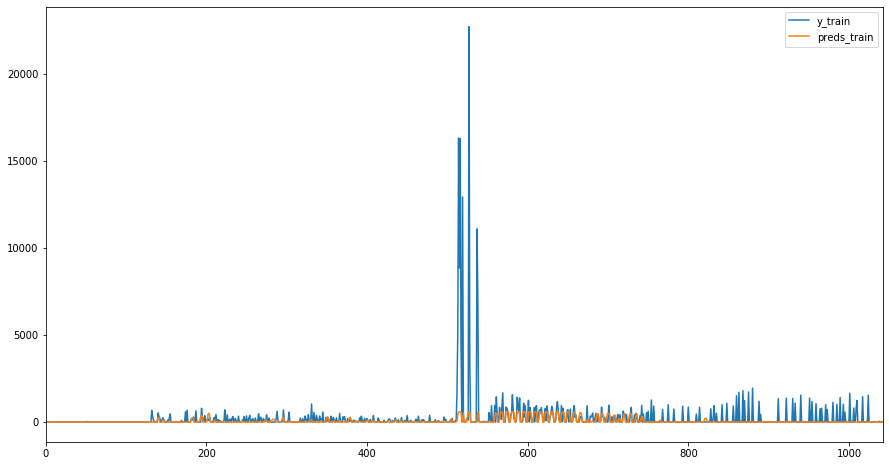

In [36]:
df_preds_train.plot(figsize=(15, 8))

----

# Predict binary target

In [255]:
df_fin = pd.read_csv('../data_processed/df_features_fornitori.csv')
df_fin['Data_Aggiudicazione/Abilitazione'] = pd.to_datetime(df_fin['Data_Aggiudicazione/Abilitazione'],
                                                              format="%Y-%m-%d")
df_fin.set_index('Data_Aggiudicazione/Abilitazione', inplace=True)

In [256]:
df_fin['target'] = (df_fin['target'].shift(-1) > df_fin['target']).astype(int)

In [257]:
df_fin = df_fin[:-1]

In [258]:
features = [col for col in df_fin.columns if col != 'target']
def rolling_window(a, window):
    shape = (a.shape[0] - window + 1, window) + a.shape[1:]
    strides = (a.strides[0],) + a.strides
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

## Baselines

### Split train test

In [259]:
X = df_fin[features].values
y = df_fin['target'].values
index = df_fin.index
X_train, y_train, index_train = X[:int(0.7 * len(X))], y[:int(0.7 * len(X))], index[:int(0.7 * len(X))]
X_test, y_test, index_test = X[int(0.7 * len(X)):], y[int(0.7 * len(X)):], index[int(0.7 * len(X)):]

### Scale feats

In [260]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Allzeros, random

In [261]:
class BaselinePredictor():
    
    def __init__(self, predictor='allzeros'): #  'random'
        self.predictor = predictor
    
    def fit(self, X_train, y_train):
        pass
    
    def predict(self, X):
        if self.predictor == 'allzeros':
            return np.full(len(X), 0)
        elif self.predictor == 'random':
            return np.random.randint(2, size=len(X))

In [262]:
allzp = BaselinePredictor(predictor='allzeros')
allzp.fit(X_train, y_train)
randp = BaselinePredictor(predictor='random')
randp.fit(X_train, y_train)


In [263]:
preds_train = allzp.predict(X_train)
preds_test = allzp.predict(X_test)
print('Train accuracy allzeros:', accuracy_score(y_train, preds_train))
print('Test accuracy allzeros: ', accuracy_score(y_test, preds_test))
print('CM train allzeros')
print(confusion_matrix(y_train, preds_train))
print('CM test allzeros') 
print(confusion_matrix(y_test, preds_test))

preds_train = randp.predict(X_train)
preds_test = randp.predict(X_test)
print('Train accuracy random:', accuracy_score(y_train, preds_train))
print('Test accuracy random: ', accuracy_score(y_test, preds_test))
print('CM train random')
print(confusion_matrix(y_train, preds_train))
print('CM test random') 
print(confusion_matrix(y_test, preds_test))

Train accuracy allzeros: 0.6719924812030075
Test accuracy allzeros:  0.6228070175438597
CM train allzeros
[[715   0]
 [349   0]]
CM test allzeros
[[284   0]
 [172   0]]
Train accuracy random: 0.47650375939849626
Test accuracy random:  0.5197368421052632
CM train random
[[353 362]
 [195 154]]
CM test random
[[141 143]
 [ 76  96]]


### Logistic regression

In [264]:
from sklearn.linear_model import LogisticRegression

In [265]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

/home/fdz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [266]:
preds_train = lr.predict(X_train)
preds_test = lr.predict(X_test)
print('Train error:', accuracy_score(y_train, preds_train))
print('Test error: ', accuracy_score(y_test, preds_test))
print('CM train')
print(confusion_matrix(y_train, preds_train))
print('CM test') 
print(confusion_matrix(y_test, preds_test))

Train error: 0.6729323308270677
Test error:  0.625
CM train
[[715   0]
 [348   1]]
CM test
[[284   0]
 [171   1]]


### xgboost

In [267]:
from xgboost import XGBClassifier

In [268]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [269]:
preds_train = xgb.predict(X_train)
preds_test = xgb.predict(X_test)
print('Train error:', accuracy_score(y_train, preds_train))
print('Test error: ', accuracy_score(y_test, preds_test))
print('CM train')
print(confusion_matrix(y_train, preds_train))
print('CM test') 
print(confusion_matrix(y_test, preds_test))

Train error: 0.7640977443609023
Test error:  0.6271929824561403
CM train
[[707   8]
 [243 106]]
CM test
[[252  32]
 [138  34]]


## Sequences

### Split train test

In [270]:
window_size = 30
scale = 'True'
if scale:
    X_rolled = rolling_window(scaler.transform(X), window_size)
else:
    X_rolled = rolling_window(X, window_size)
y_rolled = rolling_window(y, window_size)[:, -1]
index_rolled = rolling_window(index.values, window_size)[:, -1]

In [271]:
X_train, y_train = X_rolled[:int(0.7 * len(X_rolled))], y_rolled[:int(0.7 * len(y_rolled))]
X_test, y_test = X_rolled[int(0.7 * len(X_rolled)):], y_rolled[int(0.7 * len(y_rolled)):]

In [272]:
X_train, y_train = X_rolled[:int(0.7 * len(X_rolled))], y_rolled[:int(0.7 * len(y_rolled))]
index_train = index_rolled[:int(0.7 * len(y_rolled))]
X_test, y_test = X_rolled[int(0.7 * len(X_rolled)):], y_rolled[int(0.7 * len(y_rolled)):]
index_test = index_rolled[int(0.7 * len(y_rolled)):]

### Model gru

In [273]:
gru = build_model_gru(X_train.shape[2], window_size, 
                      nb_hidden_1=100, nb_hidden_2=50, emb_dim=20, 
                      dropout_1=0.2, dropout_2=0.5, rec_dropout_1=0.2, rec_dropout_2=0.5, 
                      model_type='classification')
gru.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_part (InputLayer)      (None, 30, 78)            0         
_________________________________________________________________
gru_9 (GRU)                  (None, 30, 100)           53700     
_________________________________________________________________
gru_10 (GRU)                 (None, 50)                22650     
_________________________________________________________________
dense_9 (Dense)              (None, 20)                1020      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 21        
Total params: 77,391
Trainable params: 77,391
Non-trainable params: 0
_________________________________________________________________


In [326]:
gru.fit(X_train, y_train, epochs=100)

Epoch 1/100
1043/1043 [==============================] - 2s 2ms/step - loss: 0.6487 - acc: 0.6520
Epoch 2/100
1043/1043 [==============================] - 1s 853us/step - loss: 0.6361 - acc: 0.6654
Epoch 3/100
1043/1043 [==============================] - 1s 850us/step - loss: 0.6198 - acc: 0.6644
Epoch 4/100
1043/1043 [==============================] - 1s 861us/step - loss: 0.6089 - acc: 0.6692
Epoch 5/100
1043/1043 [==============================] - 1s 888us/step - loss: 0.6038 - acc: 0.6654
Epoch 6/100
1043/1043 [==============================] - 1s 877us/step - loss: 0.5927 - acc: 0.6663
Epoch 7/100
1043/1043 [==============================] - 1s 903us/step - loss: 0.5859 - acc: 0.6721
Epoch 8/100
1043/1043 [==============================] - 1s 888us/step - loss: 0.5813 - acc: 0.6836
Epoch 9/100
1043/1043 [==============================] - 1s 922us/step - loss: 0.5685 - acc: 0.6779
Epoch 10/100
1043/1043 [==============================] - 1s 921us/step - loss: 0.5726 - acc: 0.6731
E

1043/1043 [==============================] - 1s 1ms/step - loss: 0.4196 - acc: 0.7987
Epoch 84/100
1043/1043 [==============================] - 1s 1ms/step - loss: 0.4367 - acc: 0.7881
Epoch 85/100
1043/1043 [==============================] - 1s 1ms/step - loss: 0.4242 - acc: 0.8102
Epoch 86/100
1043/1043 [==============================] - 1s 1ms/step - loss: 0.4270 - acc: 0.7977
Epoch 87/100
1043/1043 [==============================] - 1s 1ms/step - loss: 0.4327 - acc: 0.7833
Epoch 88/100
1043/1043 [==============================] - 1s 1ms/step - loss: 0.4196 - acc: 0.8092
Epoch 89/100
1043/1043 [==============================] - 1s 1ms/step - loss: 0.4216 - acc: 0.8063
Epoch 90/100
1043/1043 [==============================] - 1s 1ms/step - loss: 0.4040 - acc: 0.8121
Epoch 91/100
1043/1043 [==============================] - 1s 1ms/step - loss: 0.4292 - acc: 0.7852
Epoch 92/100
1043/1043 [==============================] - 1s 1ms/step - loss: 0.4025 - acc: 0.8102
Epoch 93/100
1043/1043 

In [327]:
preds_train = gru.predict(X_train)
preds_train = (preds_train > 0.5).astype(int).flatten()
preds_test = gru.predict(X_test)
preds_test = (preds_test > 0.5).astype(int).flatten()
print('Train error:', accuracy_score(y_train, preds_train))
print('Test error: ', accuracy_score(y_test, preds_test))
print('CM train')
print(confusion_matrix(y_train, preds_train))
print('CM test') 
print(confusion_matrix(y_test, preds_test))

Train error: 0.8446788111217641
Test error:  0.6607142857142857
CM train
[[627  67]
 [ 95 254]]
CM test
[[187  93]
 [ 59 109]]


# Results visualization

In [331]:
df_preds_test = pd.DataFrame()

In [332]:
df_preds_test['ep_tot'] = df_fin[df_fin.index.isin(index_test)]['ep_tot']

In [333]:
df_preds_test['y_test'] = y_test 
df_preds_test['preds_test'] = preds_test
df_preds_test['is_correct'] = (df_preds_test['y_test'] == df_preds_test['preds_test']).astype(int)
df_preds_test.reindex(index_test)

,ep_tot,y_test,preds_test,is_correct
Data_Aggiudicazione/Abilitazione,,,,
2019-01-08,12.0,0,0,1
2019-01-09,2.0,1,0,0
2019-01-10,2496.0,0,0,1
2019-01-11,0.0,0,0,1
2019-01-12,0.0,0,0,1
...,...,...,...,...
2020-03-26,1.0,1,0,0
2020-03-27,690.0,0,0,1
2020-03-28,0.0,0,0,1


In [334]:
df_preds_test.reset_index(inplace=True)
df_preds_test['Data_Aggiudicazione/Abilitazione'] = pd.to_datetime(df_preds_test['Data_Aggiudicazione/Abilitazione']).astype(np.int64)

In [335]:
df_preds_test

,Data_Aggiudicazione/Abilitazione,ep_tot,y_test,preds_test,is_correct
0,1546905600000000000,12.0,0,0,1
1,1546992000000000000,2.0,1,0,0
2,1547078400000000000,2496.0,0,0,1
3,1547164800000000000,0.0,0,0,1
4,1547251200000000000,0.0,0,0,1
...,...,...,...,...,...
443,1585180800000000000,1.0,1,0,0
444,1585267200000000000,690.0,0,0,1
445,1585353600000000000,0.0,0,0,1
446,1585440000000000000,0.0,1,1,1


In [336]:
def get_date_from_int(intts):
    ts = pd.to_datetime(intts)
    return "{}-{}-{}".format(ts.year, ts.month, ts.day)
    

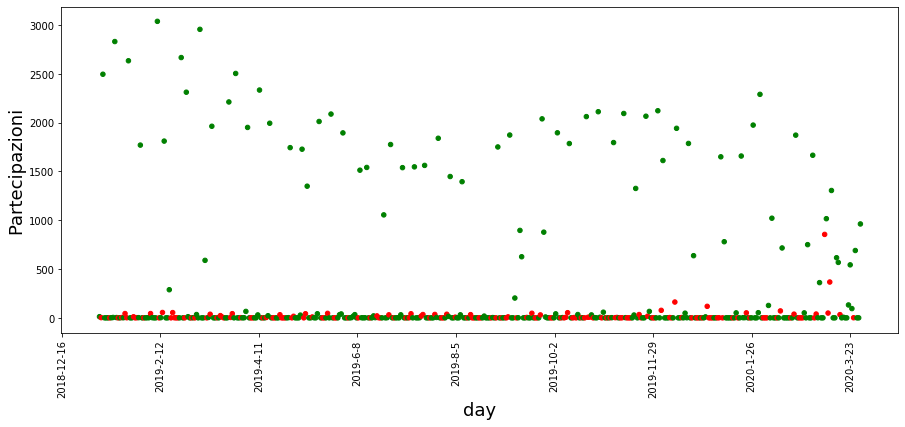

In [339]:
colors = np.where(df_preds_test["is_correct"]==1,'g','r')
ax = df_preds_test.plot.scatter(x='Data_Aggiudicazione/Abilitazione', y='ep_tot' ,c=colors, figsize = (15, 6))
ax.set_xticklabels([get_date_from_int(ts) for ts in ax.get_xticks()])
ax.set_xlabel('day', fontsize=18)
ax.set_ylabel('Partecipazioni', fontsize=18)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(10) 
    # specify integer or one of preset strings, e.g.
    #tick.label.set_fontsize('x-small') 
    tick.label.set_rotation('vertical')
#ax = df_preds_test['ep_tot'].plot(style='.', color=colors)
#ax.set_xticklabels(index_test)